In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import shap
import os
from datetime import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
import xgboost as xgb
import joblib
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
def standard_scaler_np(arr):
    mean_val = np.mean(arr)
    std_val = np.std(arr)
    scaled_arr = (arr - mean_val) / std_val
    return scaled_arr

In [3]:
data_A  = pd.read_csv("F:/New_Drugs/Li_Endo/Li_Endo_Training.csv")  # Ganti dengan lokasi dataset A
data_A1 = data_A.drop(columns=['Sample_ID', 'Drug_Name', 'risk_level', 'Vm_Peak', 'Ca_Peak', 'Vm_Resting'])
print(data_A1)

       dVm/dt_repol  Max_dVm/dt       APD90       APD50  APDtri  Ca_Diastole  \
0         -0.300345  250.237212  391.600435  318.450435  73.150     0.000082   
1         -0.317049  252.406287  370.700439  303.150439  67.550     0.000082   
2         -0.279408  252.691407  420.275299  340.875299  79.400     0.000083   
3         -0.255510  251.527446  455.900506  365.575506  90.325     0.000082   
4         -0.298442  252.932589  394.375319  321.325319  73.050     0.000083   
...             ...         ...         ...         ...     ...          ...   
21995     -0.298215  250.843263  350.900470  281.325470  69.575     0.000074   
21996     -0.283611  250.457216  371.725455  297.850455  73.875     0.000074   
21997     -0.290358  250.842534  366.000421  293.750421  72.250     0.000075   
21998     -0.281967  250.401090  374.300405  300.075404  74.225     0.000075   
21999     -0.280863  250.389663  376.475531  301.800531  74.675     0.000075   

            CaD90  CaD50  Catri      qN

In [4]:
X_data_bfr = data_A1.drop(['risk_code'], axis=1)
y_data_label = data_A1['risk_code']
print(X_data_bfr)
print(y_data_label)

       dVm/dt_repol  Max_dVm/dt       APD90       APD50  APDtri  Ca_Diastole  \
0         -0.300345  250.237212  391.600435  318.450435  73.150     0.000082   
1         -0.317049  252.406287  370.700439  303.150439  67.550     0.000082   
2         -0.279408  252.691407  420.275299  340.875299  79.400     0.000083   
3         -0.255510  251.527446  455.900506  365.575506  90.325     0.000082   
4         -0.298442  252.932589  394.375319  321.325319  73.050     0.000083   
...             ...         ...         ...         ...     ...          ...   
21995     -0.298215  250.843263  350.900470  281.325470  69.575     0.000074   
21996     -0.283611  250.457216  371.725455  297.850455  73.875     0.000074   
21997     -0.290358  250.842534  366.000421  293.750421  72.250     0.000075   
21998     -0.281967  250.401090  374.300405  300.075404  74.225     0.000075   
21999     -0.280863  250.389663  376.475531  301.800531  74.675     0.000075   

            CaD90  CaD50  Catri      qN

In [5]:
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data_label)

In [6]:
X_data = standard_scaler_np(X_data_bfr)
# X_data=X_data_bfr
print(X_data)

       dVm/dt_repol  Max_dVm/dt     APD90     APD50    APDtri  Ca_Diastole  \
0         -0.535007   -0.090278 -0.293807 -0.250641 -0.407125     0.299458   
1         -1.011130    1.276417 -0.619938 -0.567263 -0.746554     0.242951   
2          0.061780    1.456066  0.153645  0.213423 -0.028299     0.412473   
3          0.742968    0.722675  0.709553  0.724574  0.633890     0.299458   
4         -0.480771    1.608030 -0.250507 -0.191148 -0.413187     0.355966   
...             ...         ...       ...       ...       ...          ...   
21995     -0.474294    0.291584 -0.928904 -1.018913 -0.623814    -1.621792   
21996     -0.058008    0.048342 -0.603943 -0.676941 -0.363182    -1.508778   
21997     -0.250324    0.291124 -0.693279 -0.761788 -0.461676    -1.339255   
21998     -0.011147    0.012979 -0.563763 -0.630898 -0.341967    -1.395763   
21999      0.020321    0.005779 -0.529821 -0.595198 -0.314692    -1.395763   

          CaD90     CaD50     Catri      qNet   qInward  
0    

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


In [ ]:
# Define the number of features
num_features = 14

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def create_model(units1=6, units2=6, optimizer='adam'):
    # Create a function to build the model based on hyperparameters
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(num_features,)))
    model.add(Dense(units2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Create a KerasClassifier for use in GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'units1': [12],
    'units2': [11],
    'optimizer': ['adam']  # Add optimizers to the grid
}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1)
grid_result = grid.fit(X_data, y_data)

# Get the best hyperparameters
best_units1 = grid_result.best_params_['units1']
best_units2 = grid_result.best_params_['units2']
best_optimizer = grid_result.best_params_['optimizer']
unit1 = str(best_units1)
unit2 = str(best_units2)

# Train the best model using 10-fold cross-validation and 1000 epochs
fold = 0
for train_index, test_index in skf.split(X_data, y_data):
    fold += 1
    X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    model = create_model(units1=best_units1, units2=best_units2, optimizer=best_optimizer)

    current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Callback to save model at each epoch with epoch number in the filename
    checkpoint = ModelCheckpoint(
        f"F:/New_Drugs/Li_Endo/ANN_14_Feature2-node1_{unit1}-node2_{unit2}-oprimizer_{best_optimizer}/Model-{current_time}-fold-{fold}-epoch-{{epoch}}.hdf5",
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        mode='min',
        save_freq='epoch'
    )

    # Callback to save training history to a CSV file
    csv_logger = CSVLogger(f"F:/New_Drugs/Li_Endo/ANN_14_Feature2-node1_{unit1}-node2_{unit2}-oprimizer_{best_optimizer}/training_log_fold_{fold}.csv", separator=',', append=False)

    def on_epoch_end(epoch, logs):
        # Callback to save training metrics (loss and accuracy) and validation metrics
        with open(f"F:/New_Drugs/Li_Endo/ANN_14_Feature2-node1_{unit1}-node2_{unit2}-oprimizer_{best_optimizer}/training_log_fold_{fold}.csv", 'a') as file:
            file.write(f'{epoch + 1},{logs["loss"]:.4f},{logs["accuracy"]:.4f},{logs["val_loss"]:.4f},{logs["val_accuracy"]:.4f}\n')

    epoch_end_callback = on_epoch_end

    callbacks_list = [checkpoint, csv_logger]

    # One-hot encode the labels
    y_train_encoded = to_categorical(y_train, num_classes=3)
    y_test_encoded = to_categorical(y_test, num_classes=3)

    model.fit(X_train, y_train_encoded, epochs=1000, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=callbacks_list)


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Kelas untuk lapisan RBF
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[1]),
                                       initializer=RandomUniform(minval=-1, maxval=1),
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        C = K.expand_dims(self.centers)
        H = K.transpose(C - K.transpose(inputs))
        return K.exp(-self.gamma * K.sum(H ** 2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

    def get_config(self):
        config = super(RBFLayer, self).get_config()
        config.update({
            'units': self.units,
            'gamma': self.gamma
        })
        return config

# Fungsi untuk membuat model RBF network
def create_rbf_model(input_shape, units_rbf, gamma):
    model = Sequential()
    model.add(RBFLayer(units_rbf, gamma, input_shape=(input_shape,)))
    model.add(Dense(3, activation='softmax'))  # Contoh untuk 3 kelas
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:

# Konfigurasi RBF network
input_shape = X_data.shape[1]
units_rbf = 10  # Contoh: 10 neuron RBF
gamma = 1.0  # Parameter gamma untuk fungsi RBF

model = create_rbf_model(input_shape, units_rbf, gamma)

# Setup untuk model checkpoint dan CSV logger
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_dir = f"F:/New_Drugs/Li_Endo/RBF_{current_time}/"
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, 'Model11f-{epoch:03d}-{val_accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger(os.path.join(model_dir, 'training_log.csv'), append=True)

# Pelatihan model dengan validasi
y_data_encoded = to_categorical(y_data, num_classes=3)
model.fit(X_data, y_data_encoded, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[checkpoint, csv_logger])


Epoch 1/1000
476/550 [========================>.....] - ETA: 0s - loss: 1.0167 - accuracy: 0.5811
Epoch 00001: val_accuracy improved from -inf to 0.80773, saving model to F:/New_Drugs/Li_Endo/RBF_20240314-110552\Model11f-001-0.8077.hdf5
550/550 [==============================] - 1s 692us/step - loss: 0.9907 - accuracy: 0.5964 - val_loss: 0.8999 - val_accuracy: 0.8077
Epoch 2/1000
480/550 [=========================>....] - ETA: 0s - loss: 0.7174 - accuracy: 0.7747
Epoch 00002: val_accuracy did not improve from 0.80773
550/550 [==============================] - 0s 533us/step - loss: 0.7110 - accuracy: 0.7756 - val_loss: 0.7497 - val_accuracy: 0.7982
Epoch 3/1000
481/550 [=========================>....] - ETA: 0s - loss: 0.6262 - accuracy: 0.7914
Epoch 00003: val_accuracy did not improve from 0.80773
550/550 [==============================] - 0s 534us/step - loss: 0.6232 - accuracy: 0.7914 - val_loss: 0.6960 - val_accuracy: 0.7836
Epoch 4/1000
494/550 [=========================>....] - ET

In [9]:
data_testA  = pd.read_csv("F:/New_Drugs/Li_Endo/Li_Endo_Testing.csv")  # Ganti dengan lokasi dataset A
data_testA1 = data_testA.drop(columns=['Sample_ID', 'Drug_Name', 'risk_level', 'Vm_Peak', 'Ca_Peak', 'Vm_Resting'])
print(data_testA1)

       dVm/dt_repol  Max_dVm/dt       APD90       APD50   APDtri  Ca_Diastole  \
0         -0.329834  250.475067  348.200591  287.100592   61.100     0.000083   
1         -0.329827  250.681082  348.200478  287.100478   61.100     0.000083   
2         -0.329884  250.181444  348.200607  287.100607   61.100     0.000083   
3         -0.329867  250.462035  348.200344  287.100344   61.100     0.000083   
4         -0.329853  250.591458  348.200364  287.100364   61.100     0.000083   
...             ...         ...         ...         ...      ...          ...   
31980     -0.192852  247.793762  574.150367  443.650367  130.500     0.000081   
31981     -0.200770  248.506876  555.200410  431.600410  123.600     0.000081   
31982     -0.211534  248.518006  526.400475  412.700475  113.700     0.000081   
31983     -0.190929  250.188522  586.175406  451.700406  134.475     0.000081   
31984     -0.195254  247.910467  570.425342  441.500342  128.925     0.000081   

            CaD90  CaD50  C

In [10]:
X_data_test_bfr = data_testA1.drop(['risk_code'], axis=1)
y_data_test_lbl = data_testA1['risk_code']

In [11]:
label_encoder = LabelEncoder()
y_data_test = label_encoder.fit_transform(y_data_test_lbl)

In [12]:
X_data_test = standard_scaler_np(X_data_test_bfr)
# X_data_test = X_data_test_bfr
X_data_test

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


,dVm/dt_repol,Max_dVm/dt,APD90,APD50,APDtri,Ca_Diastole,CaD90,CaD50,Catri,qNet,qInward
0,-0.309415,0.301915,-0.360708,-0.321789,0.106496,-0.117227,-0.488659,-0.504416,-0.343023,0.283020,-0.097472
1,-0.309394,0.311516,-0.360709,-0.321790,0.106496,-0.117227,-0.488659,-0.504416,-0.343023,0.283033,-0.097475
2,-0.309578,0.288232,-0.360708,-0.321789,0.106496,-0.117227,-0.488659,-0.504416,-0.343023,0.283121,-0.098056
3,-0.309525,0.301308,-0.360710,-0.321790,0.106496,-0.117227,-0.488659,-0.504416,-0.343023,0.283096,-0.097664
4,-0.309477,0.307340,-0.360709,-0.321790,0.106496,-0.117227,-0.488659,-0.504416,-0.343023,0.283090,-0.097704
...,...,...,...,...,...,...,...,...,...,...,...
31980,0.133906,0.176960,0.959226,0.371449,0.783260,-0.289151,0.427388,0.589351,0.247752,-0.592880,0.106116
31981,0.108281,0.210193,0.848526,0.318089,0.715973,-0.271959,0.319809,0.382422,0.206050,-0.528364,0.004560
31982,0.073446,0.210712,0.680285,0.234396,0.619432,-0.271959,0.251350,0.589351,0.060094,-0.425576,0.027616
31983,0.140131,0.288562,1.029473,0.407096,0.822022,-0.271959,0.417608,0.254323,0.355482,-0.647757,0.161803


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Tentukan direktori tempat model-model Anda disimpan
model_dir = "F:/New_Drugs/Li_Endo/RBF_20240312-155004/"

# List semua file model yang ada di direktori
model_files = glob.glob(os.path.join(model_dir, '*.hdf5'))

# Inisialisasi list untuk menyimpan hasil pengujian
results = []

# Loop melalui setiap model
for model_file in model_files:
    # Load model
    model = load_model(model_file)

    # Lakukan prediksi pada data uji
    y_pred = model.predict(X_data_test)
    
    # Hitung metrik-metrik evaluasi
#     accuracy = accuracy_score(Y_merged_df, y_pred)
#     f1 = f1_score(Y_merged_df, y_pred, average='weighted')  # You can choose the appropriate average method

#     # Hitung metrik-metrik evaluasi
    accuracy = accuracy_score(y_true=y_data_test, y_pred=np.argmax(y_pred, axis=1))
    f1 = f1_score(y_true=y_data_test, y_pred=np.argmax(y_pred, axis=1), average='weighted')  # Atau 'micro', 'macro', dll. sesuai dengan kebutuhan
#     roc_auc = roc_auc_score(y_true=Y_merged_df, y_pred=np.argmax(y_pred, axis=1), average='weighted')  # Atau 'micro', 'macro', dll. sesuai dengan kebutuhan
#     avg_precision = average_precision_score(Y_merged_df.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')  # Atau 'micro', 'macro', dll. sesuai dengan kebutuhan

    # Simpan hasil pengujian
    result = {
        'Model': os.path.basename(model_file),
        'Accuracy': accuracy,
        'F1 Score': f1,
#         'AUC': roc_auc,
#         'Average Precision': avg_precision
    }
    results.append(result)

# Buat dataframe dari hasil pengujian
results_df = pd.DataFrame(results)

results_df.to_csv('F:/New_Drugs/Li_Endo/RBF_20240312-155004/Hasil_one_test_ORd_01.csv', index=False)

In [14]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Tentukan direktori tempat model-model Anda disimpan
model_dir = "F:/New_Drugs/Li_Endo/RBF_20240314-110552/"

# List semua file model yang ada di direktori
model_files = glob.glob(os.path.join(model_dir, '*.hdf5'))

# Inisialisasi list untuk menyimpan hasil pengujian
results = []

# Modify the loading process to include custom_objects
for model_file in model_files:
    model = load_model(model_file, custom_objects={'RBFLayer': RBFLayer})

    # Proceed with your code for prediction and evaluation
    y_pred = model.predict(X_data_test)
    accuracy = accuracy_score(y_true=y_data_test, y_pred=np.argmax(y_pred, axis=1))
    f1 = f1_score(y_true=y_data_test, y_pred=np.argmax(y_pred, axis=1), average='weighted')
    
    # Store and process your results as needed
    result = {
        'Model': os.path.basename(model_file),
        'Accuracy': accuracy,
        'F1 Score': f1,
    }
    results.append(result)

# Continue with your result processing
results_df = pd.DataFrame(results)
results_df.to_csv('F:/New_Drugs/Li_Endo/RBF_20240314-110552/Hasil_one_test_ORd_01.csv', index=False)

In [15]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
import xgboost as xgb
import joblib
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model_test = load_model("F:/New_Drugs/Li_Endo/RBF_20240314-110552/Model11f-001-0.8077.hdf5", custom_objects={'RBFLayer': RBFLayer})

In [ ]:
columns_to_drop = ['risk_level', 'risk_code', 'Sample_ID']
encoded_df_column_list = X_data_test.columns.difference(columns_to_drop)

In [ ]:
explainer = shap.KernelExplainer(model_test.predict, X_data.values[:1000])  # Using the first 100 examples as background
shap_values = explainer.shap_values(X_data.values[:1000])

In [ ]:
shap.summary_plot(shap_values, plot_type="bar", class_names= ['High-risk', 'Intermediate-risk', 'Low-risk'], feature_names = X_data_test.columns, show=False)
plt.ylabel("Features")
plt.xlabel("Mean (|SHAP Value|)")
# plt.savefig("F:/7. Result/running_bu_yunen/ord/ANN_14_Feature2-node1_12-node2_11-oprimizer_adam/ANN_Sum_Feature_Importance.jpg")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming 'shap_values' is a list of arrays, where each array corresponds to a class
# and 'X_data_test_bfr.columns' gives you the feature names.

# Colors and class names for each class
class_colors = ['#EC2CAC', '#077CDB', '#7E8511']
class_names = ['High-risk', 'Intermediate-risk', 'Low-risk']

# Output directory for saving TIFF files
output_directory = 'F:/New_Drugs/Li_Endo/RBF_20240312-155004/'  # Change to your specific directory

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Prepare data for the stacked bar plot
feature_names = X_data_test_bfr.columns
num_features = len(feature_names)
num_classes = len(shap_values)
mean_abs_shap_values = np.abs(shap_values).mean(axis=1)  # Mean across samples for each class

# Accumulate total SHAP values for each feature
total_shap_values = np.sum(mean_abs_shap_values, axis=0)

# Create the bar plot
plt.figure(figsize=(10, 6))
bars_data = np.zeros(num_features)  # Initialize the bottom of the bars

for class_index in range(num_classes):
    # Mean across samples for this class
    mean_vals = mean_abs_shap_values[class_index]
    plt.barh(feature_names, mean_vals, left=bars_data, color=class_colors[class_index],
             edgecolor='black', height=0.5, label=class_names[class_index])
    bars_data += mean_vals  # Update the bottom for the next stack

# Add text with the total SHAP value outside of each stacked bar
for i, (feature_name, total_val) in enumerate(zip(feature_names, total_shap_values)):
    plt.text(bars_data[i], i, f'{total_val:.2f}', ha='left', va='center', color='black', fontsize=8)

# Customize the plot
plt.xlabel('Mean (|SHAP Value|)')
plt.ylabel('Features')
plt.title('Summary of SHAP Values by Class')
plt.grid(axis='x')
plt.legend(loc='lower right')

# Save the plot as a TIFF file with DPI 300
output_file_path = os.path.join(output_directory, 'SHAP_Summary_Stacked_Plot1.tif')
plt.savefig(output_file_path, format='tiff', dpi=300)
plt.close()

print(f"Plot saved successfully at: {output_file_path}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming 'shap_values' is a list of arrays, where each array corresponds to a class
# and 'X_data_test_bfr.columns' gives you the feature names.

# Colors and class names for each class
class_colors = ['#EC2CAC', '#077CDB', '#7E8511']
class_names = ['High-risk', 'Intermediate-risk', 'Low-risk']

# Output directory for saving TIFF files
output_directory = 'F:/New_Drugs/Li_Endo/RBF_20240312-155004/'  # Change to your specific directory

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Prepare data for the stacked bar plot
feature_names = X_data_test_bfr.columns
num_features = len(feature_names)
num_classes = len(shap_values)
mean_abs_shap_values = np.abs(shap_values).mean(axis=1)  # Mean across samples for each class

# Accumulate total SHAP values for each feature
total_shap_values = np.sum(mean_abs_shap_values, axis=0)

# Sort features by total SHAP values from highest to lowest
sorted_indices = np.argsort(total_shap_values)  # The minus sign is for descending order
sorted_feature_names = feature_names[sorted_indices]
sorted_total_shap_values = total_shap_values[sorted_indices]

# Create the sorted stacked bar plot
plt.figure(figsize=(10, 6))
bars_data = np.zeros(num_features)  # Initialize the bottom of the bars

for class_index in range(num_classes):
    # Sort the mean values according to the sorted feature indices
    sorted_mean_vals = mean_abs_shap_values[class_index][sorted_indices]
    
    # Plot sorted stacked bars
    plt.barh(sorted_feature_names, sorted_mean_vals, left=bars_data, color=class_colors[class_index],
             edgecolor='black', height=0.5, label=class_names[class_index])
    bars_data += sorted_mean_vals  # Update the bottom for the next stack

# Add text with the total SHAP value outside of each stacked bar
for i, total_val in enumerate(sorted_total_shap_values):
    plt.text(bars_data[i], i, f'{total_val:.2f}', ha='left', va='center', color='black', fontsize=8)

# Customize the plot
plt.xlabel('Mean (|SHAP Value|)')
plt.ylabel('Features')
plt.title('Summary of SHAP Values by Class')
plt.grid(axis='x')
plt.legend(loc='lower right')

# Save the plot as a TIFF file with DPI 300
output_file_path = os.path.join(output_directory, 'SHAP_Summary_Stacked_Plot2.tif')
plt.savefig(output_file_path, format='tiff', dpi=300)
plt.close()

print(f"Plot saved successfully at: {output_file_path}")

In [ ]:
shap.summary_plot(shap_values, plot_type="bar", feature_names = X_data_test.columns, show=False)
plt.ylabel("Features")
plt.xlabel("Mean (|SHAP Value|)")
plt.savefig("F:/7. Result/running_bu_yunen/ord/ANN_14_Feature2-node1_12-node2_11-oprimizer_adam/ANN_Sum_Feature_Importance_a.jpg")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
plt.show()

In [ ]:
for i in range(len(shap_values)):
    shap.summary_plot(shap_values[i], X_data.values[:1000], feature_names = X_data_test_bfr.columns, show=False)
    # plt.title("Distribution of SHAP values for each feature in the 'Intermediate-Risk' class")
    plt.ylabel("Feature")
    plt.xlabel("SHAP Value")
    plt.savefig("F:/New_Drugs/Li_Endo/RBF_20240312-155004/SHAP_Value_HIL_Risk_{0}.jpg".format(i))
    # plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
    plt.show()

In [ ]:
import shap

for i in range(len(shap_values)):
    # Menghitung expected value secara keseluruhan
    overall_expected_value = explainer.expected_value[0]

    # Menggabungkan SHAP values dari beberapa baris data
    merged_shap_values = shap_values[i].mean(axis=0)

    scaled_shap_values = merged_shap_values * 10000
    
    plt.figure(figsize=(10, 6)) 

    # Meringkas waterfall plot untuk semua baris data
    shap.plots._waterfall.waterfall_legacy(overall_expected_value, scaled_shap_values, 
                                           feature_names = X_data_test_bfr.columns, max_display=20, show=False)
#     plt.ylabel("Feature name")
#     plt.xlabel("Mean (SHAP Value)")
    plt.savefig("F:/New_Drugs/Li_Endo/RBF_20240312-155004/plot_HIL_Risk_{0}.tiff".format(i), dpi=300, format='tiff')
#     plt.savefig("E:/backup_CML_1/New_Drugs/Li_Endo/Result_Revision_1/12f_svm/plot_HIL_Risk_{0}.jpg".format(i))
    # plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Daftar warna yang akan digunakan, satu warna untuk setiap kelas
class_colors = ['#EC2CAC','#077CDB','#7E8511']

# Output directory for saving TIFF files
output_directory = 'F:/7. Result/running_bu_yunen/ord/ANN_14_Feature2-node1_12-node2_11-oprimizer_adam/'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterasi untuk setiap kelas
for class_index in range(len(shap_values)):
    j = str(class_index)
    x
    # Menghitung expected value secara keseluruhan
    overall_expected_value = explainer.expected_value[0]

    # Menggabungkan SHAP values dari beberapa baris data (tanpa nilai absolut)
    merged_shap_values = np.mean(np.abs(shap_values[class_index]), axis=0)

    scaled_shap_values = merged_shap_values

    # Memilih warna berdasarkan indeks kelas
    class_color = class_colors[class_index % len(class_colors)]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(X_data_test_bfr.columns, scaled_shap_values, color=class_color)
    plt.xlabel('SHAP Values')
    plt.ylabel('Feature Names')
    plt.title("SHAP Values for Class_" + j)
    plt.grid(axis='x')
    # Menambahkan nilai detail pada setiap batang
    # Menambahkan nilai detail pada setiap batang di luar batang, di paling kanan
    for bar, shap_value in zip(bars, scaled_shap_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{shap_value:.3f}', ha='left', va='center', color='black')

    # Save the plot as a TIFF file with DPI 300
    output_file_path = os.path.join(output_directory, f'SHAP_Plot_Class_{j}.tif')
    plt.savefig(output_file_path, format='tiff', dpi=300)
    plt.close()  # Close the plot to avoid displaying it in the notebook

print("Plots saved successfully.")


In [ ]:
import matplotlib.pyplot as plt

# Daftar warna yang akan digunakan, satu warna untuk setiap kelas
class_colors = ['#077CDB', '#EC2CAC', '#7E8511']

# Iterasi untuk setiap kelas
for class_index in range(len(shap_values)):
    j = str(class_index)
    
    # Menghitung expected value secara keseluruhan
    overall_expected_value = explainer.expected_value[0].numpy()

    # Menggabungkan SHAP values dari beberapa baris data (tanpa nilai absolut)
    merged_shap_values = np.mean(shap_values[class_index], axis=0)

    scaled_shap_values = merged_shap_values * 1000000000

    # Memilih warna berdasarkan indeks kelas
    class_color = class_colors[class_index % len(class_colors)]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(X_data.columns, scaled_shap_values, color=class_color)
    plt.xlabel('SHAP Values')
    plt.ylabel('Feature Names')
    plt.title("SHAP Values for Class_" + j)
    plt.grid(axis='x')
    # Menambahkan nilai detail pada setiap batang
    # Menambahkan nilai detail pada setiap batang di luar batang, di paling kanan
    for bar, shap_value in zip(bars, scaled_shap_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{shap_value:.3f}', ha='left', va='center', color='black')
    plt.show()

In [16]:
data_testAs  = pd.read_csv("E:/backup_CML_1/New_Drugs/Li_Endo/Li_Endo_Testing.csv")  # Ganti dengan lokasi dataset A
data_testAs1 = data_testAs.drop(columns=['Sample_ID', 'Drug_Name', 'risk_level', 'risk_code'])
data_testAs1 = standard_scaler_np(data_testAs1)
data_name = data_testAs['Drug_Name']
data_test_ID = data_testAs['Sample_ID'].astype(int)
data_risk = data_testAs['risk_level']

data_test_n = pd.concat([data_test_ID, data_testAs1, data_name, data_risk], axis=1)


print(data_test_n)

       Sample_ID  dVm/dt_repol_O  Max_dVm/dt_O  Vm_Peak_O  Vm_Resting_O  \
0              0       -0.309415      0.301915   0.540256     -0.247994   
1              1       -0.309394      0.311516   0.540124     -0.247993   
2              2       -0.309578      0.288232   0.540750     -0.247994   
3              3       -0.309525      0.301308   0.540873     -0.247993   
4              4       -0.309477      0.307340   0.540587     -0.247993   
...          ...             ...           ...        ...           ...   
31980       1995        0.133906      0.176960   0.583957     -0.248853   
31981       1996        0.108281      0.210193   0.561629     -0.248734   
31982       1997        0.073446      0.210712   0.483378     -0.248760   
31983       1998        0.140131      0.288562   0.555272     -0.248777   
31984       1999        0.126133      0.182399   0.637444     -0.248717   

        APD90_O   APD50_O  APDtri_O  Ca_Peak_O  Ca_Diastole_O   CaD90_O  \
0     -0.360708 -0.32178

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Load model ANN Anda yang sudah dilatih
model = model_test

# Daftar unik dari jenis 'Drug_Name' dalam dataset
unique_drug_names = data_test_n['Drug_Name'].unique()

# Inisialisasi list untuk menyimpan semua confusion matrix
all_confusion_matrices = []
drug_combination = []
d_X_test = []
accu = []
accu_h = []
accu_i = []
accu_l = []
f1_sc = []
f1_sc_h = []
f1_sc_i = []
f1_sc_l = []
lr_p_h = []
lr_p_i = []
lr_p_l = []
lr_n_h = []
lr_n_i = []
lr_n_l = []
auc_high = []
auc_inter = []
auc_low = []

# Lakukan iterasi sebanyak 10.000 kali
for _ in range(10000):
    # Pilih secara acak 16 'Drug_Name' yang berbeda
    unique_drug_names = np.random.choice(data_test_n['Drug_Name'].unique(), 16, replace=False)

    # Inisialisasi list untuk menyimpan 16 sampel
    selected_combinations = []

    # Memilih satu sampel dengan 'Drug_Name' yang sesuai untuk setiap 'Drug_Name' yang telah dipilih
    for drug_name in unique_drug_names:
        selected_sample = data_test_n[data_test_n['Drug_Name'] == drug_name].sample(1)
        selected_combinations.append(selected_sample)

    # Menggabungkan 16 sampel menjadi satu DataFrame
    selected_combinations = pd.concat(selected_combinations)

    # Pisahkan fitur dan target sesuai kebutuhan Anda
    X_test = selected_combinations.drop(columns=['Sample_ID', 'Drug_Name', 'risk_level', 'Vm_Peak_O', 'Ca_Peak_O', 'Vm_Resting_O'])  # Sesuaikan dengan struktur dataset Anda
    y_test = selected_combinations['risk_level']  # Sesuaikan dengan struktur dataset Anda
    y_test = label_encoder.fit_transform(y_test)
    
    # Uji model dengan data uji
    y_pred = model.predict(X_test)

    # Hitung confusion matrix
    cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))  # Sesuaikan dengan nilai threshold yang sesuai
#     print(cm)
    
    tp_high = cm[0,0]
    tn_high = cm[1,1]+cm[1,2]+cm[2,1]+cm[2,2]
    fp_high = cm[1,0]+cm[2,0]
    fn_high = cm[0,1]+cm[0,2]

    tp_inter = cm[1,1]
    tn_inter = cm[0,0]+cm[0,2]+cm[2,0]+cm[2,2]
    fp_inter = cm[0,1]+cm[2,1]
    fn_inter = cm[1,0]+cm[1,2]

    tp_low = cm[2,2]
    tn_low = cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]
    fp_low = cm[0,2]+cm[1,2]
    fn_low = cm[2,0]+cm[2,1]

    acc_high = (tp_high+tn_high)/(tp_high+tn_high+fp_high+fn_high)
    pre_high = tp_high/(tp_high+fp_high)
    rec_high = tp_high/(tp_high+fn_high)
    spe_high = tn_high/(tn_high+fp_high)
    lrp_high = rec_high/(1-spe_high)
    lrn_high = (1-rec_high)/spe_high
    f1s_high = (2*pre_high*rec_high)/(pre_high+rec_high)

    acc_inter = (tp_inter+tn_inter)/(tp_inter+tn_inter+fp_inter+fn_inter)
    pre_inter = tp_inter/(tp_inter+fp_inter)
    rec_inter = tp_inter/(tp_inter+fn_inter)
    spe_inter = tn_inter/(tn_inter+fp_inter)
    lrp_inter = rec_inter/(1-spe_inter)
    lrn_inter = (1-rec_inter)/spe_inter
    f1s_inter = (2*pre_inter*rec_inter)/(pre_inter+rec_inter)

    acc_low = (tp_low+tn_low)/(tp_low+tn_low+fp_low+fn_low)
    pre_low = tp_low/(tp_low+fp_low)
    rec_low = tp_low/(tp_low+fn_low)
    spe_low = tn_low/(tn_low+fp_low)
    lrp_low = rec_low/(1-spe_low)
    lrn_low = (1-rec_low)/spe_low
    f1s_low = (2*pre_low*rec_low)/(pre_low+rec_low)
    
    acc = (acc_high+acc_inter+acc_low)/3
    f1_s = (f1s_high+f1s_inter+f1s_low)/3
    
#     fpr_high, tpr_high, _ = roc_curve(y_test == 0, y_pred[:, 0])
#     roc_auc_high = auc(fpr_high, tpr_high)
    

#     fpr_inter, tpr_inter, _ = roc_curve(y_test == 1, y_pred[:, 1])
#     roc_auc_inter = auc(fpr_inter, tpr_inter)
    

#     fpr_low, tpr_low, _ = roc_curve(y_test == 2, y_pred[:, 2])
#     roc_auc_low = auc(fpr_low, tpr_low)
    
    roc_auc_high = roc_auc_score(y_test == 0, y_pred[:, 0])
    roc_auc_inter = roc_auc_score(y_test == 1, y_pred[:, 1])
    roc_auc_low = roc_auc_score(y_test == 2, y_pred[:, 2])
    
#     if acc >= 0.70:
    auc_high.append(roc_auc_high)
    auc_inter.append(roc_auc_inter)
    auc_low.append(roc_auc_low)

    # Simpan confusion matrix ke dalam list
    drug_combination.append(selected_combinations)
    all_confusion_matrices.append(cm)
    d_X_test.append(X_test)
    accu.append(acc)
    accu_h.append(acc_high)
    accu_i.append(acc_inter)
    accu_l.append(acc_low)
    f1_sc.append(f1_s)
    f1_sc_h.append(f1s_high)
    f1_sc_i.append(f1s_inter)
    f1_sc_l.append(f1s_low)
    lr_p_h.append(lrp_high)
    lr_p_i.append(lrp_inter)
    lr_p_l.append(lrp_low)
    lr_n_h.append(lrn_high)
    lr_n_i.append(lrn_inter)
    lr_n_l.append(lrn_low)
    
# Buat DataFrame dari list
df_result = pd.DataFrame({'Drug_Combination': drug_combination, 
                        'X_data': d_X_test, 
                        'Confusion_Matrix': all_confusion_matrices,
                        'Acc' : accu,
                        'Acc_High': accu_h,
                         'Acc_Inter': accu_i,
                         'Acc_Low': accu_l,
                        'AUC_High': auc_high,
                        'AUC_Inter': auc_inter,
                        'AUC_Low': auc_low,
                         'F1_S': f1_sc,
                         'F1_S_High': f1_sc_h,
                         'F1_S_Inter': f1_sc_i,
                         'F1_S_Low': f1_sc_l,
                         'LR_p_High': lr_p_h,
                         'LR_p_Inter': lr_p_i,
                         'LR_p_Low': lr_p_l,
                         'LR_n_High': lr_n_h,
                         'LR_n_Inter': lr_n_i,
                         'LR_n_Low': lr_n_l})

# df_result_filtered = df_result[df_result['Acc'] >= 0.70]

df_result.to_csv('F:/New_Drugs/Li_Endo/RBF_20240314-110552/Result_of_10000_Times_Test_of_Early_Fusion_ANN_22_1.csv')

invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid value encountered in longlong_scalars
invalid value encountered in double_scalars
invalid va

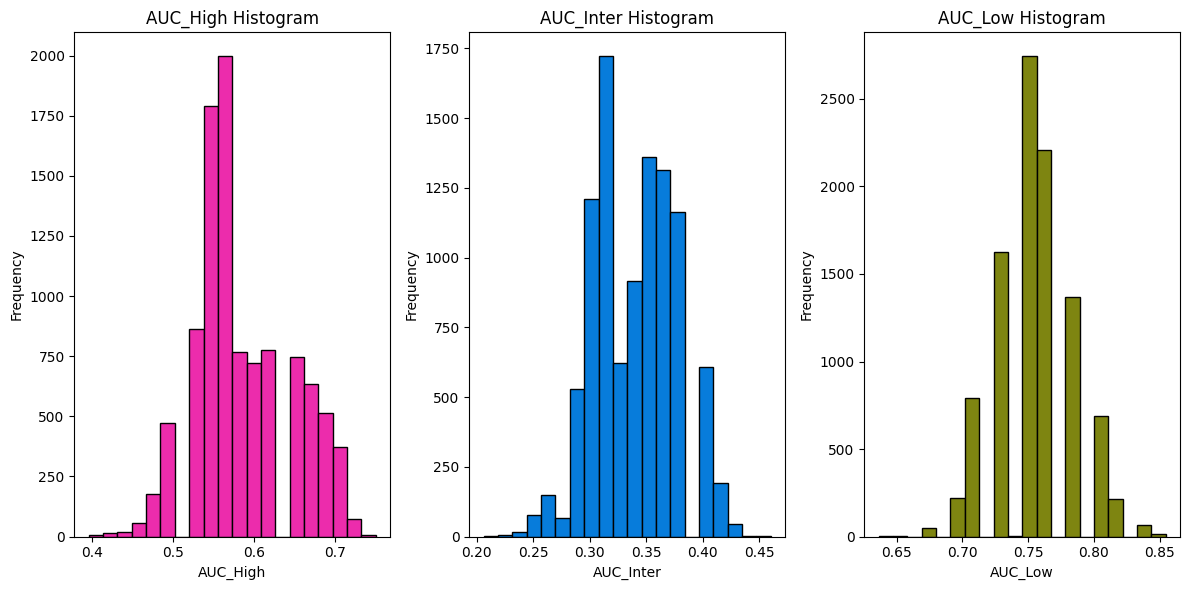

In [20]:
import matplotlib.pyplot as plt
# Define custom colors and edge colors
color_high = '#EC2CAC'  # Custom color for AUC_High
color_inter = '#077CDB'  # Custom color for AUC_Inter
color_low = '#7E8511'  # Custom color for AUC_Low
edge_color = 'black'  # Edge color

# Create a figure for the histograms
plt.figure(figsize=(12, 6))

# Histogram for 'AUC_High'
plt.subplot(131)
plt.hist(auc_high, bins=20, color=color_high, edgecolor=edge_color)
plt.title('AUC_High Histogram')
plt.xlabel('AUC_High')
plt.ylabel('Frequency')

# Histogram for 'AUC_Inter'
plt.subplot(132)
plt.hist(auc_inter, bins=20, color=color_inter, edgecolor=edge_color)
plt.title('AUC_Inter Histogram')
plt.xlabel('AUC_Inter')
plt.ylabel('Frequency')

# Histogram for 'AUC_Low'
plt.subplot(133)
plt.hist(auc_low, bins=20, color=color_low, edgecolor=edge_color)
plt.title('AUC_Low Histogram')
plt.xlabel('AUC_Low')
plt.ylabel('Frequency')

plt.tight_layout()  # Ensure the subplots don't overlap

# Define the file path where you want to save the histograms
output_file_path = 'F:/New_Drugs/Li_Endo/RBF_20240314-110552/AUC.png'

# Save the figure to the specified file
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')

# Show the plots (optional)
plt.show()

In [21]:
import pandas as pd
import numpy as np

# Assuming df_result is your DataFrame
columns_of_interest = ['Acc', 'Acc_High', 'Acc_Inter', 'Acc_Low', 'AUC_High', 'AUC_Inter', 'AUC_Low', 'F1_S', 'F1_S_High', 'F1_S_Inter', 'F1_S_Low', 'LR_p_High', 'LR_p_Inter', 'LR_p_Low', 'LR_n_High', 'LR_n_Inter', 'LR_n_Low']

# Calculate the median and confidence interval
medians = df_result[columns_of_interest].median()
lower_bound = df_result[columns_of_interest].quantile(0.025)
upper_bound = df_result[columns_of_interest].quantile(0.975)

# Combine median, lower, and upper into a single string with two decimal places
result_strings = medians.round(2).astype(str) + ' (' + lower_bound.round(2).astype(str) + ', ' + upper_bound.round(2).astype(str) + ')'

# Create a new DataFrame with the desired format
table = pd.DataFrame({'Median (Lower_CI, Upper_CI)': result_strings})

# Add a new column for the metric names
table['auc_detail'] = columns_of_interest

# Reorder the columns
table = table[['auc_detail', 'Median (Lower_CI, Upper_CI)']]
# Save the table to Excel
table.to_excel('F:/New_Drugs/Li_Endo/RBF_20240314-110552/Final_result_RF_01.xlsx', index=False)

# Display the table
table


,auc_detail,"Median (Lower_CI, Upper_CI)"
Acc,Acc,"0.58 (0.54, 0.58)"
Acc_High,Acc_High,"0.44 (0.38, 0.44)"
Acc_Inter,Acc_Inter,"0.56 (0.56, 0.56)"
Acc_Low,Acc_Low,"0.75 (0.69, 0.75)"
AUC_High,AUC_High,"0.56 (0.48, 0.71)"
AUC_Inter,AUC_Inter,"0.33 (0.27, 0.4)"
AUC_Low,AUC_Low,"0.75 (0.69, 0.82)"
F1_S,F1_S,"nan (nan, nan)"
F1_S_High,F1_S_High,"0.4 (0.29, 0.4)"
F1_S_Inter,F1_S_Inter,"nan (nan, nan)"


In [ ]:
# Function to calculate 95% CIs
def calculate_ci(data):
    mean_val = np.mean(data)
    ci_low, ci_high = stats.t.interval(0.95, len(data)-1, loc=mean_val, scale=stats.sem(data))
    return ci_low, ci_high

In [ ]:
# Columns to calculate statistics for
columns_of_interest = ['Acc', 'Acc_High', 'Acc_Inter', 'Acc_Low', 'AUC_High', 'AUC_Inter', 'AUC_Low', 'F1_S', 'F1_S_High', 'F1_S_Inter', 'F1_S_Low', 'LR_p_High', 'LR_p_Inter', 'LR_p_Low', 'LR_n_High', 'LR_n_Inter', 'LR_n_Low']

# Calculate median and CIs
table = df_result[columns_of_interest].agg(['median', calculate_ci]).T.reset_index()
table.columns = ['auc_detail', 'median', 'ci_low', 'ci_high']

# Round the values
table[['median', 'ci_low', 'ci_high']] = table[['median', 'ci_low', 'ci_high']].apply(lambda x: round(x, 2))

# Save to Excel
table.to_excel('D:/backup_CML_1/New_Drugs/Li_Endo/save_model_04-node1_6-node2_6-node3_6-oprimizer_adam/Final_result_RF_01.xlsx', index=False)

In [ ]:
table = df_result[['Acc', 'Acc_High','Acc_Inter','Acc_Low', 'AUC_High', 'AUC_Inter', 'AUC_Low','F1_S','F1_S_High','F1_S_Inter','F1_S_Low','LR_p_High','LR_p_Inter','LR_p_Low', 'LR_n_High', 'LR_n_Inter','LR_n_Low']].agg(['mean', 'median', 'min', 'max']).apply(lambda x: round(x, 2)).reset_index().rename(columns={'index':'auc_detail'})

table.to_excel('D:/backup_CML_1/New_Drugs/Li_Endo/save_model_04-node1_6-node2_6-node3_6-oprimizer_adam/Final_result_RF_01.xlsx', index = False)

table